### `This Notebook is for Regression Project "Houses Prices Preditction"`

### `By: Eng/ Mohamed Zahran`
### `Supervised By: Eng/ Mohammed Agoor`

-------------

### `The Target is (medina_house_value), and Evaluation Metric is (RMSE)`

---------

### `Import the main Libraries`

In [1]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy 
import missingno 
import joblib 

# sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

from xgboost import XGBRegressor

### `Load the Dataset and Look at the big Picture`

In [5]:
path = os.path.join(os.getcwd(), '..', 'dataset', 'housing.csv')
df = pd.read_csv(path)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

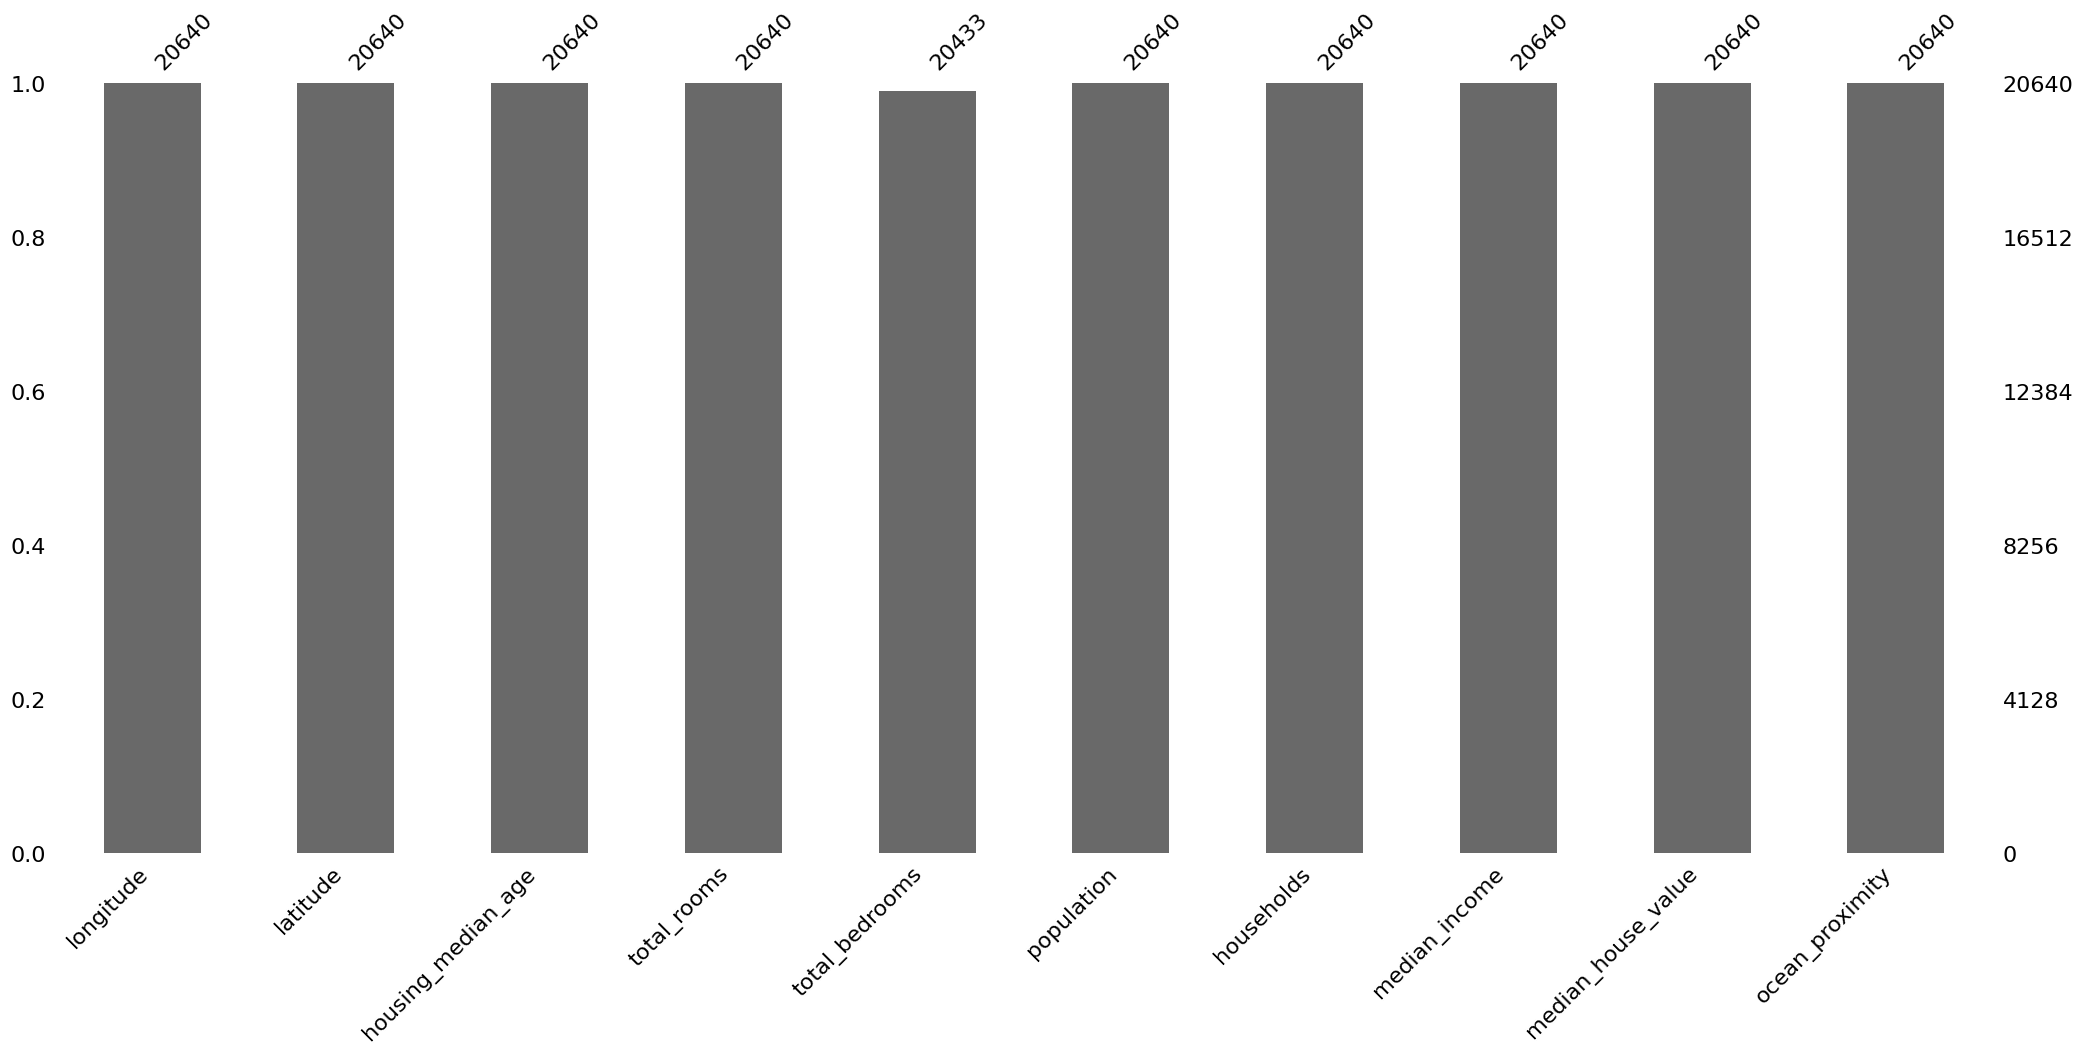

In [10]:
missingno.bar(df)
plt.show()

### `Exploratory Data Analysis`

* `Univariate Visualization`

In [12]:
ocean_values = df['ocean_proximity'].value_counts()
ocean_values

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

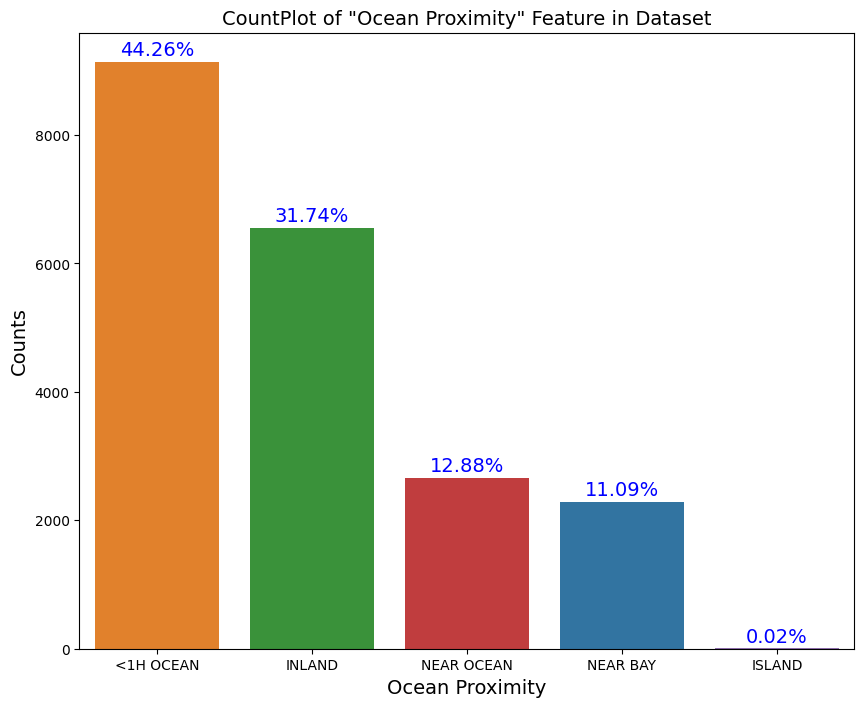

In [14]:
plt.figure(figsize=(10, 8))
sns.countplot(x='ocean_proximity', data=df, order=ocean_values.index, hue=df['ocean_proximity'])
plt.title('CountPlot of "Ocean Proximity" Feature in Dataset', fontsize=14, c='k')
plt.xlabel('Ocean Proximity', fontsize=14, c='k')
plt.ylabel('Counts', fontsize=14, c='k')

for i in range(len(ocean_values)):
    each_count = ocean_values.values[i]
    each_text = f'{((100*each_count)/ len(df)):.2f}%'
    plt.text(x=i, y=each_count+100, s=each_text, c='b', fontsize=14, ha='center')

In [16]:
## Replace the  (<1H OCEAN) to (1H OCEAN) -- will cause ane errors in Deploymnet
df['ocean_proximity'] = df['ocean_proximity'].replace('<1H OCEAN', '1H OCEAN')

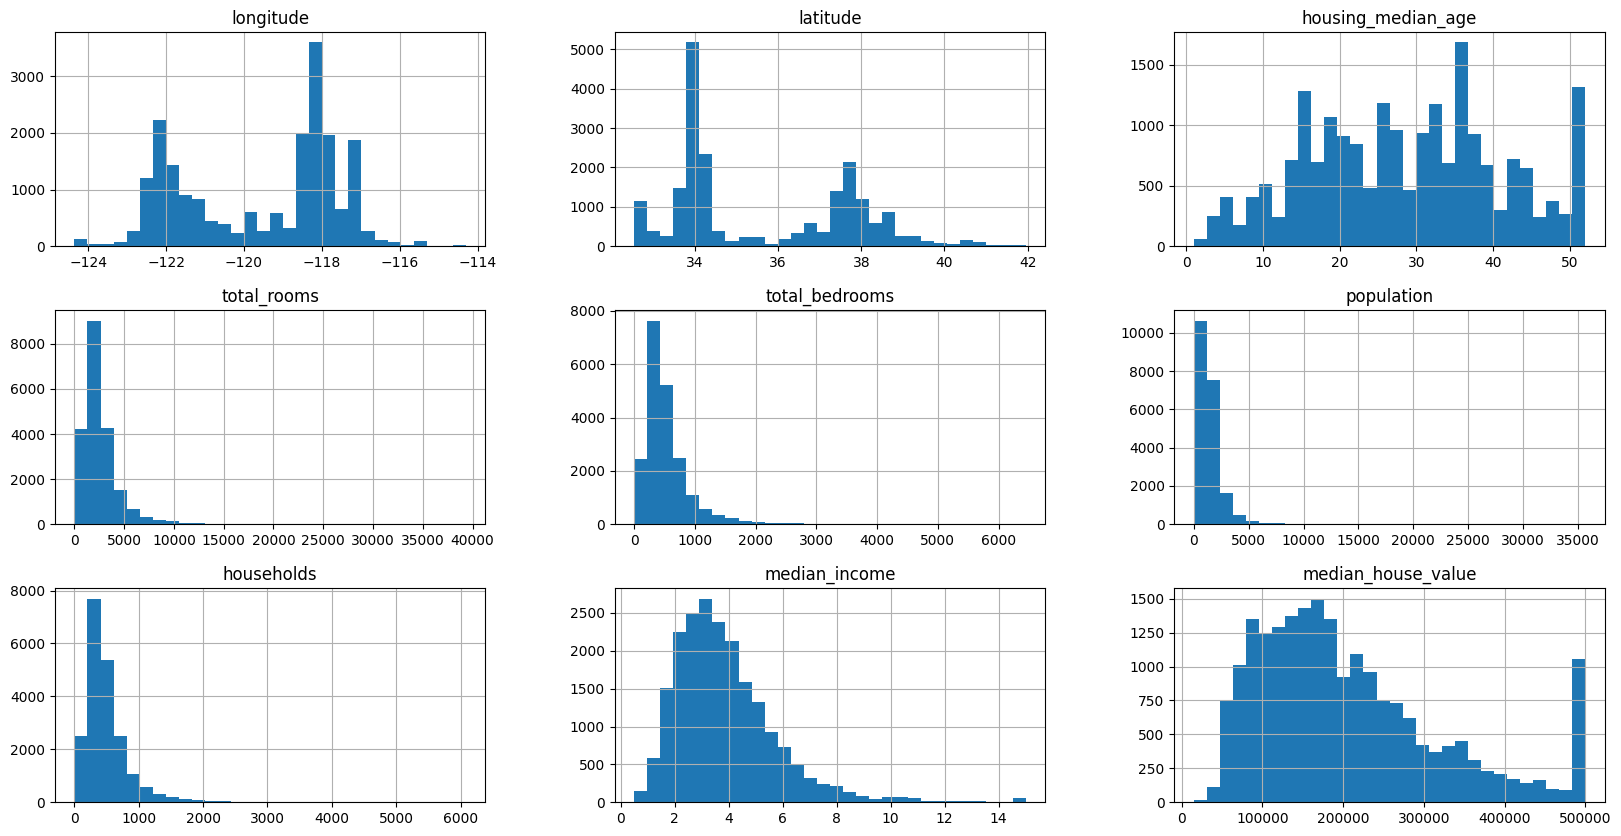

In [17]:
df.hist(bins=30, figsize=(20, 10))
plt.show()

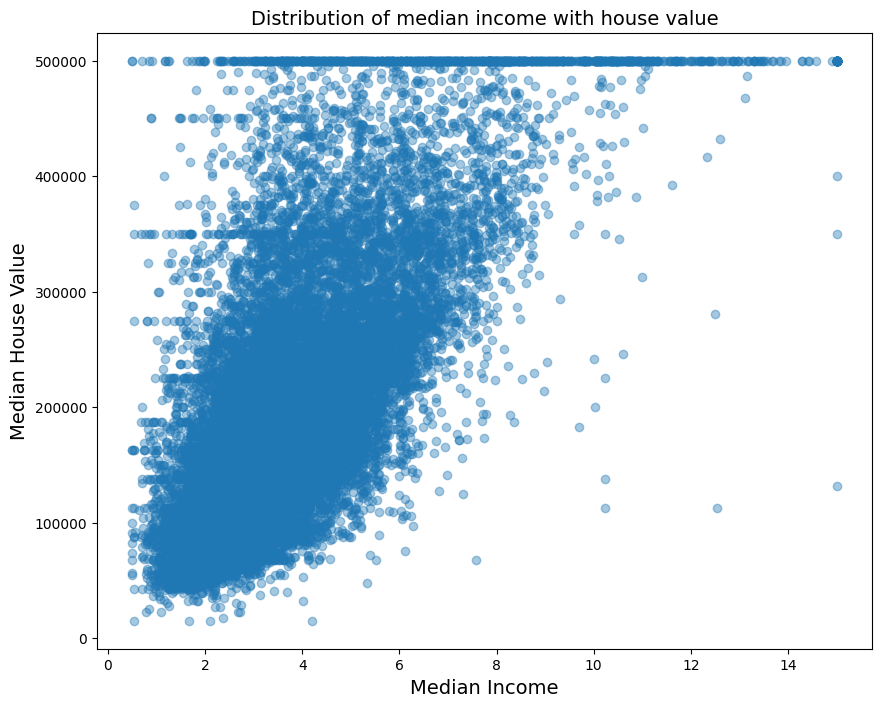

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(df['median_income'], df['median_house_value'], alpha=0.4)
plt.title('Distribution of median income with house value', fontsize=14, c='k')
plt.xlabel('Median Income', fontsize=14, c='k')
plt.ylabel('Median House Value', fontsize=14, c='k')
plt.show()

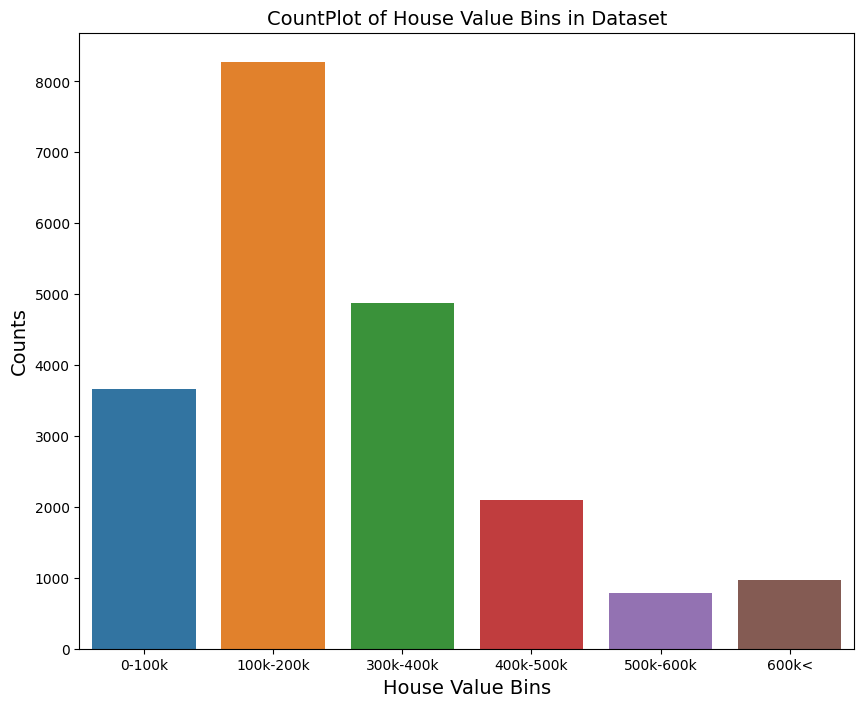

In [20]:
house_value_bins = pd.cut(x=df['median_house_value'], 
                          bins=[-np.inf, 100000, 200000, 300000, 400000, 500000, np.inf],
                          labels=['0-100k', '100k-200k', '300k-400k', '400k-500k', '500k-600k', '600k<'])

plt.figure(figsize=(10, 8))
sns.countplot(x=house_value_bins, hue=house_value_bins)
plt.title('CountPlot of House Value Bins in Dataset', fontsize=14, c='k')
plt.xlabel('House Value Bins', fontsize=14, c='k')
plt.ylabel('Counts', fontsize=14, c='k')
plt.show()

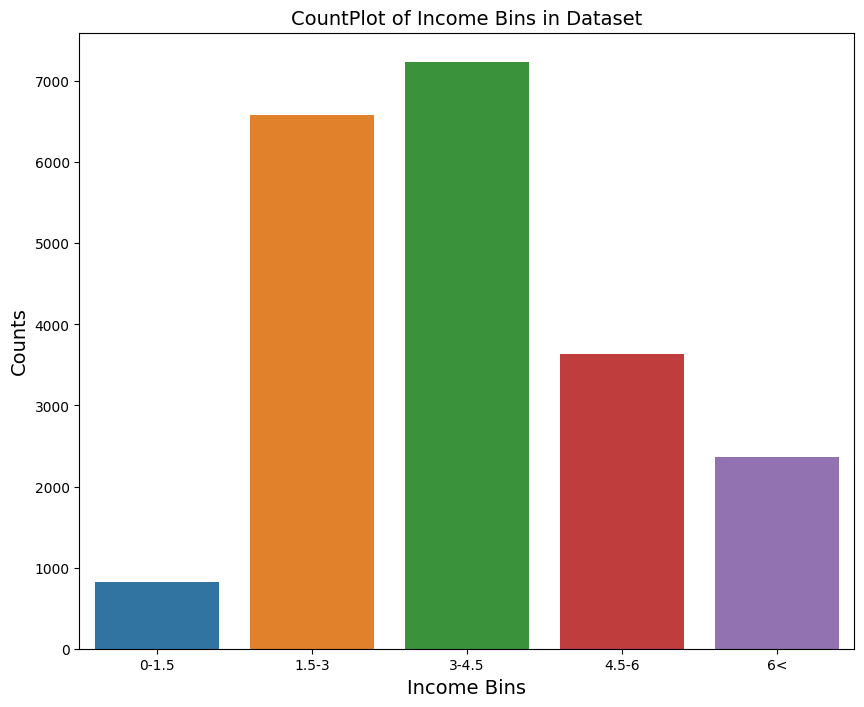

In [23]:
income_bins = pd.cut(x=df['median_income'],
                     bins=[-np.inf, 1.5, 3, 4.5, 6, np.inf],
                     labels=['0-1.5', '1.5-3', '3-4.5', '4.5-6', '6<'])

plt.figure(figsize=(10, 8))
sns.countplot(x=income_bins, hue=income_bins)
plt.title('CountPlot of Income Bins in Dataset', fontsize=14, c='k')
plt.xlabel('Income Bins', fontsize=14, c='k')
plt.ylabel('Counts', fontsize=14, c='k')
plt.show() 

## Data Distribution Observations

After exploring the dataset, several key observations were made regarding the distribution of important features:

### 1. Ocean Proximity Bias
The category `<1H ocean` represents nearly half of the dataset, indicating a strong imbalance. This means the data is biased toward this category.  
If this feature turns out to be significant for model performance, using **stratified sampling** instead of random splitting may be necessary to ensure proportional representation of each category.

---

### 2. Right-Skewed Numerical Features
Most numerical features in the dataset exhibit **right-skewed (exponential-like) distributions**, such as:

- `median_income`
- `median_house_value`
- `population`
- `households`
- `total_rooms`

Machine learning models often perform better when inputs resemble a **normal distribution**. Therefore, transformations such as **log**, **power**, **Box-Cox**, or **Yeo-Johnson** may be applied later to reduce skewness and improve model performance.

---

### 3. House Value Distribution
The majority of houses fall within the **100k–200k** price range.  
This concentration helps illustrate the economic profile of most districts in the dataset and will directly influence how the target variable behaves.

---

### 4. Income Distribution
Most values of `median_income` lie between **3.0 and 4.5**, indicating that the dataset mainly represents middle-income districts.  
This also helps explain why income is typically one of the strongest predictors of house value.

---

### 5. Feature Selection for Stratified Sampling
Since `median_income` is likely a highly important feature for predicting `median_house_value`, it may be more effective to split the dataset using stratified sampling based on income levels.  
However, because stratified sampling requires **categorical** data, the continuous `median_income` must first be converted into **discrete bins** (for example, using `income_bins`).

This ensures that both the training and test sets maintain the same proportion of income groups, improving model generalization and reducing sampling bias.

---


### `Bivariate Visualization`

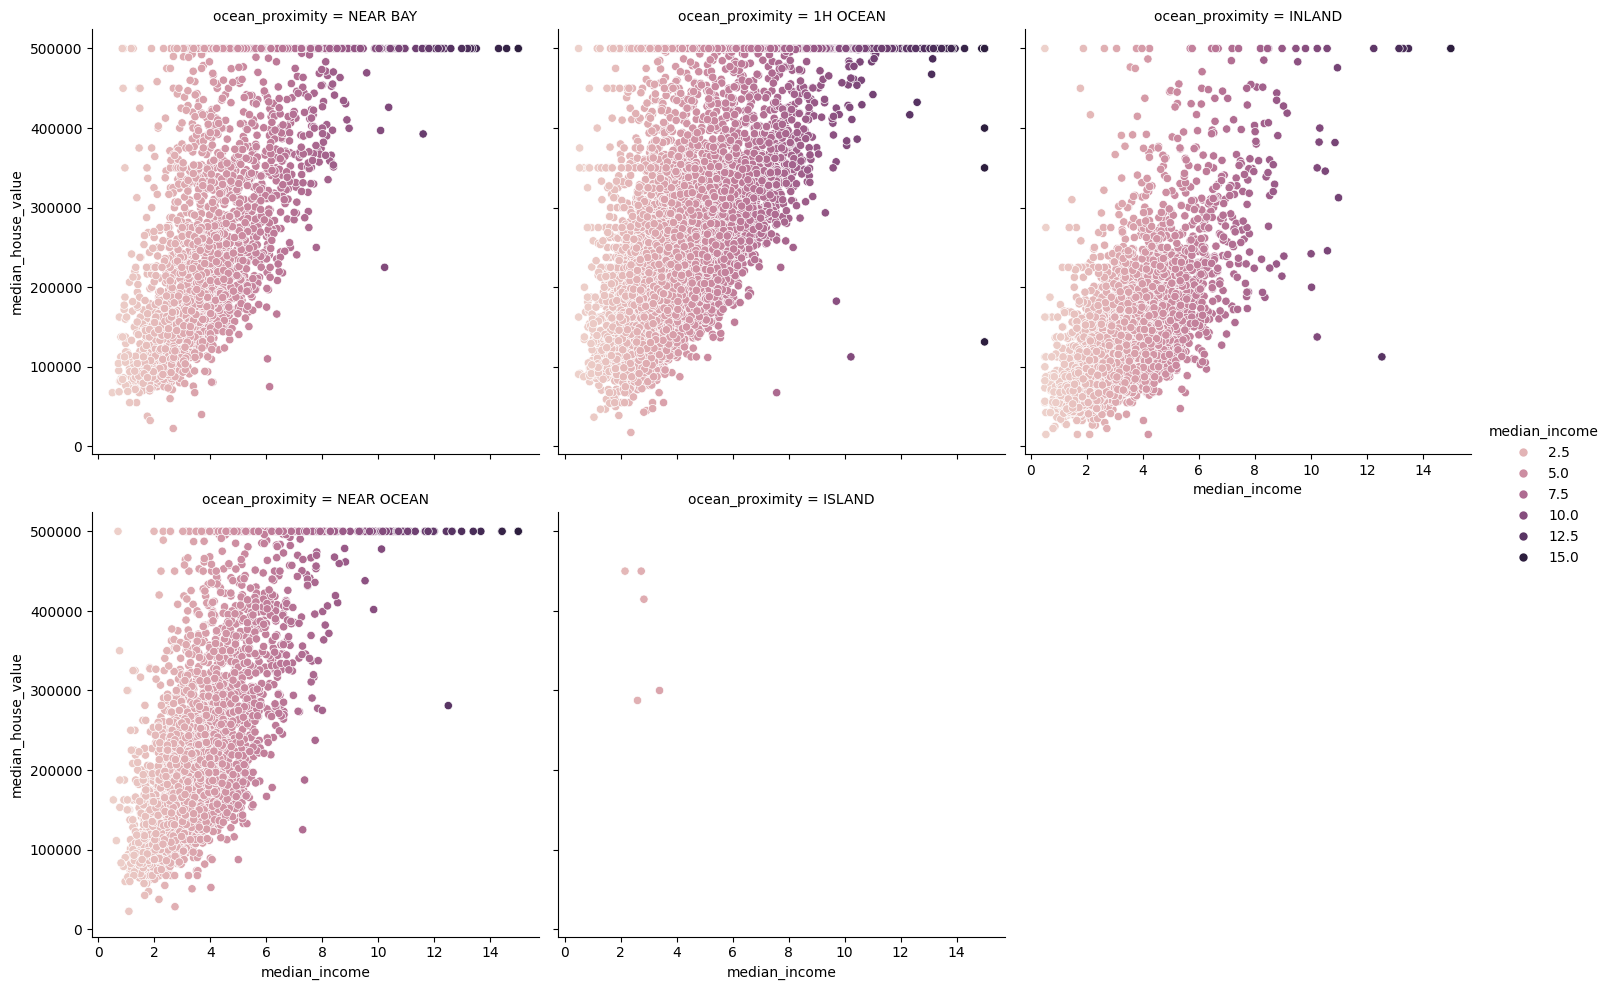

In [ ]:
sns.relplot(x='median_income', y='median_house_value', data=df, kind='scatter',
            col='ocean_proximity', col_wrap=3, hue='median_income')
plt.show()

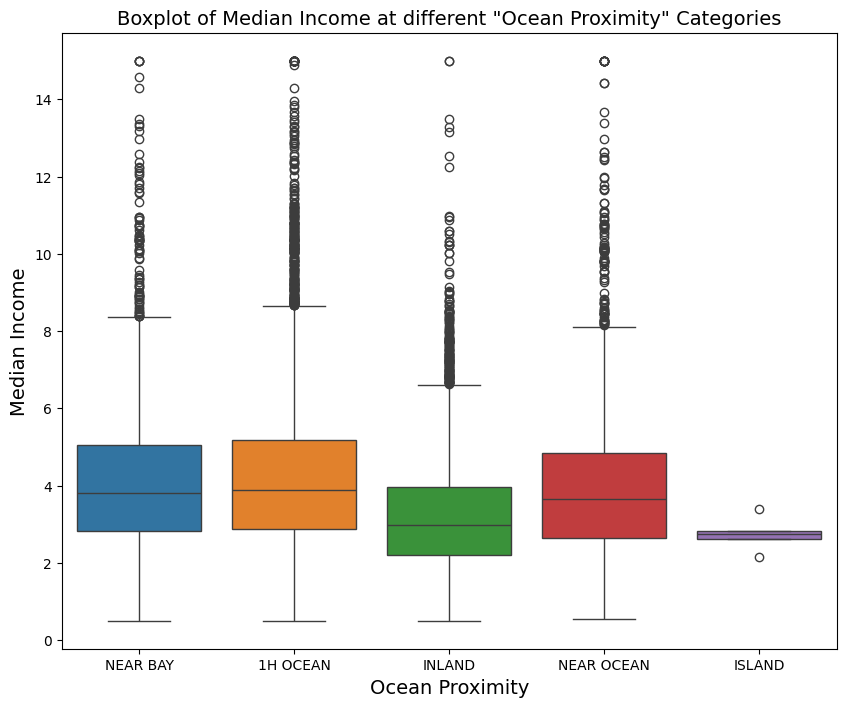

In [31]:
plt.figure(figsize=(10, 8))
sns.boxplot(y='median_income', data=df, x='ocean_proximity', hue='ocean_proximity')
plt.title('Boxplot of Median Income at different "Ocean Proximity" Categories', fontsize=14, c='k')
plt.xlabel('Ocean Proximity', fontsize=14, c='k')
plt.ylabel('Median Income', fontsize=14, c='k')
plt.show()

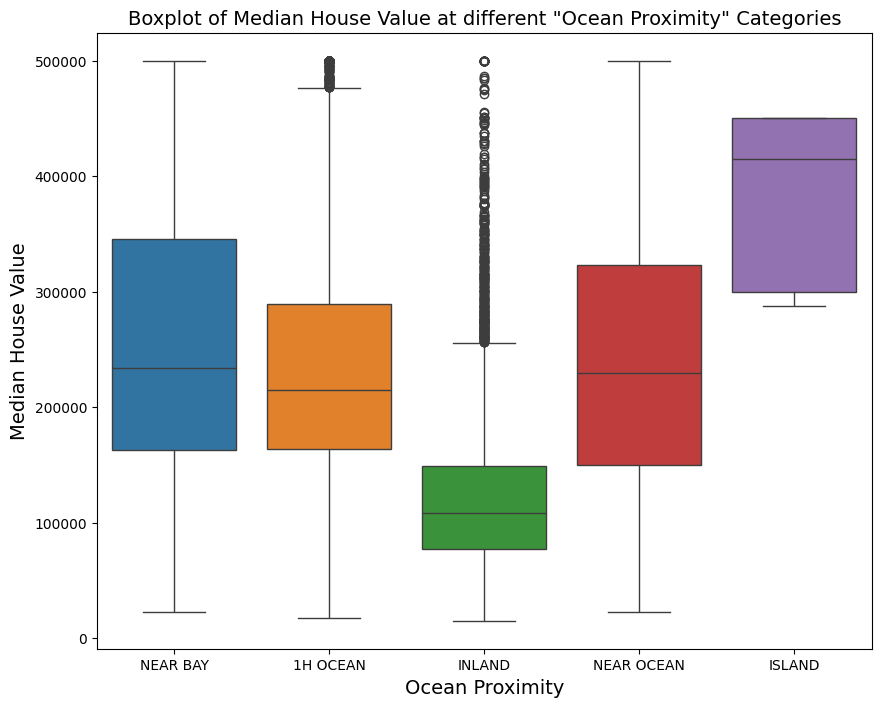

In [33]:
plt.figure(figsize=(10, 8))
sns.boxplot(y='median_house_value', data=df, x='ocean_proximity', hue='ocean_proximity')
plt.title('Boxplot of Median House Value at different "Ocean Proximity" Categories', fontsize=14, c='k')
plt.xlabel('Ocean Proximity', fontsize=14, c='k')
plt.ylabel('Median House Value', fontsize=14, c='k')
plt.show()

### Analysis of Income and Housing Values Across Ocean Proximity Categories

Upon examining the relationship between **median_income** and **ocean_proximity**, the distribution of income appears to be fairly consistent across most proximity categories. This indicates that living closer to or farther from the coastline does not significantly change the overall income distribution for the majority of groups.

However, a clear distinction is observed for the **INLAND** category. Both **median_income** and **median_house_value** are noticeably lower in inland regions compared to coastal areas. This pattern is logically expected, as inland locations typically have:

- Lower population density  
- Reduced economic activity  
- More affordable housing markets  

As a result, the **INLAND** category naturally shows lower income levels and house prices, reflecting the typical socioeconomic characteristics of non-coastal regions.


### `Multivariate Visualization`

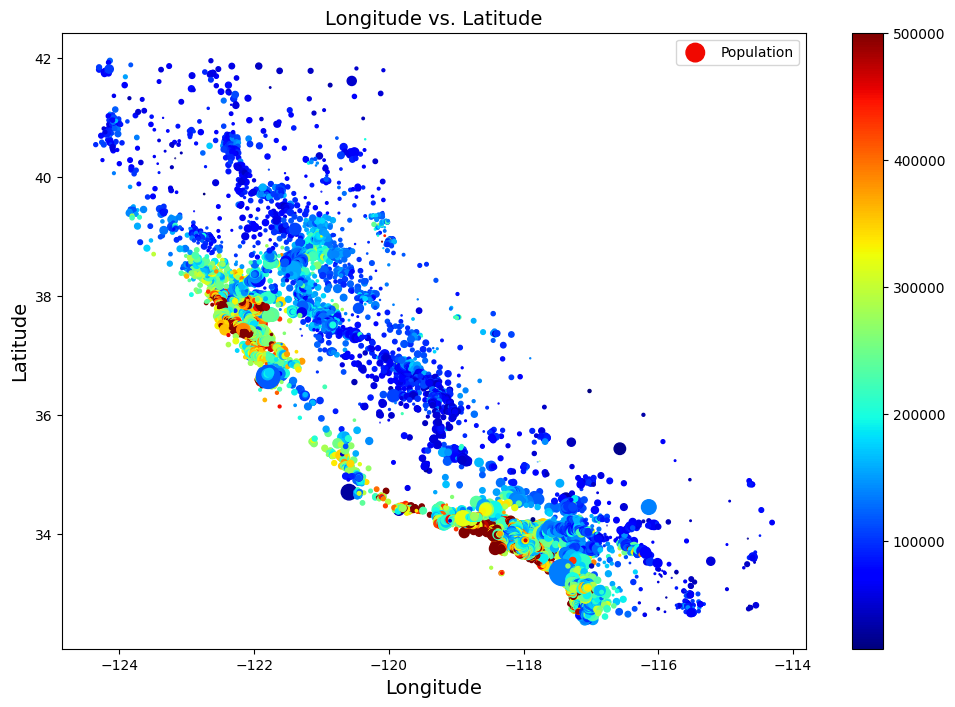

In [37]:
plt.figure(figsize=(12, 8))
cs=plt.scatter(x=df['longitude'], y=df['latitude'], 
            s=df['population']/100, c=df['median_house_value'],
            cmap=plt.get_cmap('jet'), label='Population')
plt.colorbar(cs)
plt.xlabel('Longitude', fontsize=14, c='k')
plt.ylabel('Latitude', fontsize=14, c='k')
plt.title('Longitude vs. Latitude', fontsize=14, c='k')
plt.legend()
plt.show()

### Housing Prices and Population by Ocean Proximity

Analysis of the dataset reveals that **housing prices are generally higher in areas near the ocean** compared to inland regions. In addition, these coastal areas tend to have **higher population densities**. This trend aligns with typical urban and economic patterns:

- Coastal areas often have **better amenities, services, and lifestyle advantages**.  
- Higher population density reflects **increased demand** for housing in desirable coastal locations.  
- This combination of high demand and better facilities contributes to the **elevated housing prices** in these regions.

---------------

### `Check the Correlation between the Features and Target`

In [39]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_numeric.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

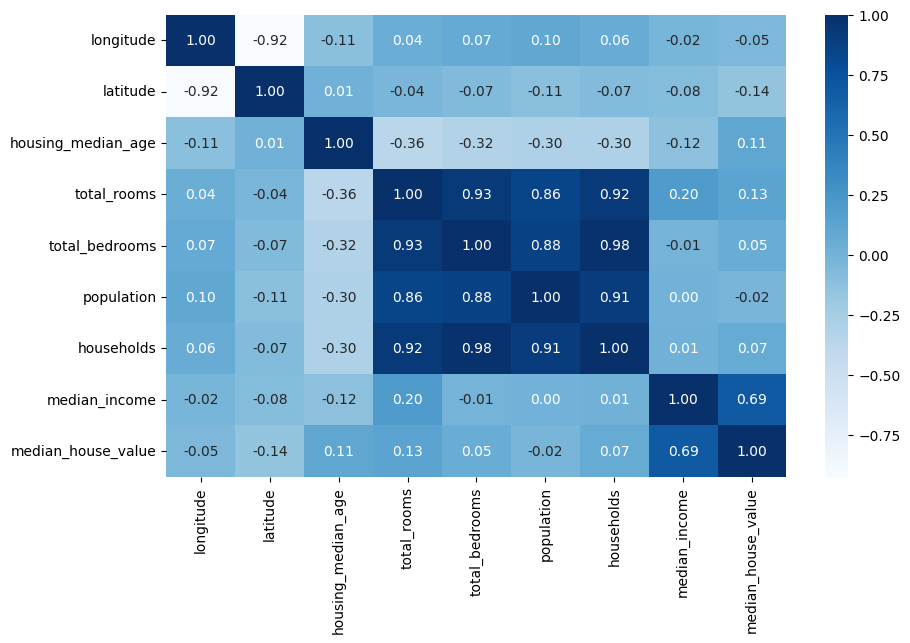

In [40]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='Blues', fmt='0.2f')
plt.show()

### Comment on Feature Correlation with Target

After calculating correlations with the target variable **median_house_value**, it appears that **median_income** is the most strongly correlated feature, as predicted.  
Features such as **households** and **population** show a weaker correlation with the target.  

This indicates that **income is the most important predictor of house value**, while the number of households and population have less influence. This insight can guide feature selection for model training and prioritization.


### `Feature Engineering`
``Try to add some features, thinking that it will be more useful and more correlated to the target``

In [41]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_rooms'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

In [42]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_numeric.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_rooms         -0.255880
Name: median_house_value, dtype: float64

### New Features

Some of the newly added features show **promising progress**, demonstrating strong correlation with the target variable (**median_house_value**).  

This indicates that these new features can be **valuable predictors** for modeling and may significantly improve model performance.


### `Split the Dataset`
``I will split the Dataset using ordinary method (random method) not (Stratified method)``

In [43]:
X = df.drop(columns=['median_house_value'], axis=1)
y = df['median_house_value']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=42)

In [46]:
print('X_train shape -- ', X_train.shape)
print('y_train shape -- ', y_train.shape)
print('X_test shape -- ', X_test.shape)
print('y_test shape -- ', y_test.shape)

X_train shape --  (17544, 12)
y_train shape --  (17544,)
X_test shape --  (3096, 12)
y_test shape --  (3096,)


# Notes about sklearn :
 .fit  → The object learns patterns/parameters from the training data only.
 .transform → Apply the learned parameters to any dataset (train/valid/test).
 .fit_transform → Performs fit + transform in one step (used only with training data).
 In practice:
 - For training data: use fit_transform() or fit() followed by transform().
- For validation/test data: use transform() only (never fit again).
 Summary:
fit = learn from training data.
 transform = apply what was learned.
fit_transform = learn + apply in one step (training data only).


### `Dealing with nulls`

In [48]:
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['float32', 'float64', 'int32', 'int64']]
categ_cols = [col for col in X_train.columns if X_train[col].dtype not in ['float32', 'float64', 'int32', 'int64']]

print('Numerical Columns : \n', num_cols)
print('\n')
print('Categorical Columns : \n', categ_cols)

Numerical Columns : 
 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_rooms', 'population_per_household']


Categorical Columns : 
 ['ocean_proximity']


In [49]:
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train[num_cols])

X_train_imputed = imputer.transform(X_train[num_cols])
X_test_imputed = imputer.transform(X_test[num_cols])

### `Standardize the Features`

In [50]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.fit_transform(X_test_imputed)

###  StandardScaler Explanation

**StandardScaler** is used to normalize numerical features so they all share the same scale:

- Mean → **0**
- Standard deviation → **1**

This improves model performance by:
- Speeding up convergence during training  
- Preventing the model from being biased toward features with large values  
- Ensuring all features contribute equally  

### Important Notes
- Use **`fit_transform()`** only on the **training data** so the scaler learns mean & std **without leaking information** from the test set.
- Use **`transform()`** on the **test data** so it’s scaled using the *same* statistics learned from the training set.

### `Pipeline for Numerical Features  --  I will use it in this Project`
`Building a pipeline is much easier and better while inference at new dataset`

In [53]:
num_pipeline = Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())
                    ])

X_train_num = num_pipeline.fit_transform(X_train[num_cols])
X_test_num = num_pipeline.transform(X_test[num_cols])

### ` Categorical Features` 

Before passing categorical features into any Machine Learning model, they must be converted into numerical values.  
Machine Learning algorithms cannot understand text directly, so encoding is required.  
Below are the most common encoding techniques:

---

### **1️ Label Encoding**
- Converts each category into a unique integer value.
- Numbers typically range from `0` to `number_of_categories - 1`.
- Best used when **categories have no inherent order**.

### **2️ Ordinal Encoding**
- Similar to Label Encoding, but used specifically for **ordered categories**.
- Encodes categories in a meaningful order (e.g., from lowest to highest).
- Should only be used when an **actual ranking** exists between categories.

### **3️ One Hot Encoding (OHE)**
- Creates a new binary column for each category.
- The active category is marked with `1` while others are `0`.
- Ideal when categories are **not ordered** and you want to avoid implying hierarchy.

In [54]:
label_encoder = LabelEncoder()
X_train_encoded = label_encoder.fit_transform(np.squeeze(X_train[categ_cols].values))
X_test_encoded = label_encoder.transform(np.squeeze(X_test[categ_cols].values))

###  `Pipeline for Categorical Features`

In this project, we will use **One Hot Encoding (OHE)** for categorical features.  

**Important Notes:**

- **Features:**  
  - Preferably use **OHE** for categorical features.  
  - You can also use **LabelEncoder** or **OrdinalEncoder**, depending on the use case.  

- **Target:**  
  - You **must** use **LabelEncoder** for encoding the target variable.  
  - Exception: In Deep Learning models, you can use OHE for the target if needed.  




In [56]:
categ_pipeline = Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                        ('OHE', OneHotEncoder(sparse_output=False))
                    ])

X_train_categ = categ_pipeline.fit_transform(X_train[categ_cols])
X_test_categ = categ_pipeline.transform(X_test[categ_cols])

### `Get all Together`
* `Now we have outputs from Numerical Pipeline and Cateforical Pipeline`
* `We have two solutions:`
    * `Conactenate the Features (Numerical after processing) and (Encoded Categorical)`
    * `You can use (FeatureUnion or ColumnTransformer) provided in sklearn`

In [58]:
## We can get much much easier like the following
## numerical pipeline
num_pipeline = Pipeline([
                        ('selector', DataFrameSelector(num_cols)),    ## select only these columns
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())
                        ])

## categorical pipeline
categ_pipeline = Pipeline(steps=[
            ('selector', DataFrameSelector(categ_cols)),    ## select only these columns
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('OHE', OneHotEncoder(sparse_output=False))])

## concatenate both two pipelines
total_pipeline = FeatureUnion(transformer_list=[
                                            ('num_pipe', num_pipeline),
                                            ('categ_pipe', categ_pipeline)
                                               ]
                             )
## deal with (total_pipeline) as an instance -- fit and transform to train dataset and transform only to other datasets
X_train_final = total_pipeline.fit_transform(X_train)
X_test_final = total_pipeline.transform(X_test)       

### `Building ML Models`

`Evaluation Metric: RMSE`

### `1. LinearRegression`

In [59]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [61]:
rmse_scores_lin = cross_val_score(estimator=lin_reg, X=X_train_final, y=y_train,
                                  cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rmse_scores_lin = -1 * rmse_scores_lin
rmse_scores_lin = np.sqrt(rmse_scores_lin)
print(f'RMSE Scores Using LinearRegression --- {np.round(rmse_scores_lin, 4)}')
print(f'Mean of RMSE Scores Using LinearRegression --- {rmse_scores_lin.mean():.4f}')


RMSE Scores Using LinearRegression --- [66469.8275 69222.723  66338.7127 67047.6716 70321.7781]
Mean of RMSE Scores Using LinearRegression --- 67880.1426


In [ ]:
y_pred_lin = cross_val_predict(estimator=lin_reg, X=X_train_final, y=y_train, cv=5, method='predict', n_jobs=-1)
rmse_pred_lin = np.sqrt(mean_squared_error(y_train, y_pred_lin))
print(f'RMSE after prediction Using LinearRegression --- {rmse_pred_lin:.4f}') 

RMSE after prediction Using LinearRegression --- 67898.8887


##  Evaluating Linear Regression Model with Cross-Validation

We evaluate the **Linear Regression** model using **cross-validation** to obtain more reliable performance metrics than a single train/test split.

---

### **1️ RMSE Scores using Cross-Validation**
- Cross-validation splits the training data into multiple folds (e.g., 5 folds).  
- The model is trained on some folds and tested on the remaining fold in each iteration.  
- RMSE (Root Mean Squared Error) is computed for each fold to measure performance.  
- Using negative mean squared error is common in scikit-learn, so we convert it to positive and then take the square root to get RMSE.  
- The mean RMSE across all folds gives an overall performance estimate.

---

### **2️ Predictions using Cross-Validation**
- `cross_val_predict` generates predictions for each training sample **as if it were in a test fold**.  
- RMSE can be calculated from these predictions and should be close to the mean RMSE from cross-validation.  
- Important: **Do not use the standard `.predict()` on training data** when performing cross-validation, as it leads to biased results.

---

###  **Key Takeaways**
- Cross-validation ensures **reliable and unbiased evaluation**.  
- RMSE is a standard metric for regression performance.  
- Using both cross-validation scores and predictions helps verify model consistency.


### `2. SGDRegressor`

In [65]:
sgd_reg = SGDRegressor(penalty='l2', alpha=0.0001, shuffle=True, max_iter=10000)
sgd_reg.fit(X_train_final, y_train)

,loss,'squared_error'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,10000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,None


In [66]:
## Check scores of this Model (RMSE) using (cross_val_score)
rmse_scores_sgd = cross_val_score(estimator=sgd_reg, X=X_train_final, y=y_train, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  ## sklearn deals with error as negative
rmse_scores_sgd = -1 * rmse_scores_sgd   
rmse_scores_sgd = np.sqrt(rmse_scores_sgd)
print(f'RMSE Scores Using SGDRegressor --- {np.round(rmse_scores_sgd, 4)}')
print(f'Mean of RMSE Scores Using SGDRegressor --- {rmse_scores_sgd.mean():.4f}')



RMSE Scores Using SGDRegressor --- [  215262.6812  6278301.2428    66634.083    905792.5651 63760454.0591]
Mean of RMSE Scores Using SGDRegressor --- 14245288.9262


In [ ]:
y_pred_sgd = cross_val_predict(estimator=sgd_reg, X=X_train_final, y=y_train, cv=5, method='predict', n_jobs=-1)

rmse_pred_sgd = np.sqrt(mean_squared_error(y_train, y_pred_sgd))
print(f'RMSE after prediction Using SGDRegressor --- {rmse_pred_sgd:.4f}') 

RMSE after prediction Using SGDRegressor --- 121492697.0813


##  Evaluating SGDRegressor Model with Cross-Validation

We evaluate the **SGDRegressor** model using **cross-validation** to get a reliable performance estimate.

---

### **1️ RMSE Scores using Cross-Validation**
- The training data is split into multiple folds (e.g., 5 folds).  
- The model is trained on a subset of folds and tested on the remaining fold in each iteration.  
- RMSE (Root Mean Squared Error) is calculated for each fold.  
- scikit-learn returns negative MSE in `cross_val_score`, so we convert it to positive and then take the square root to get RMSE.  
- The mean RMSE across all folds represents the overall performance of the model.

---

### **2️ Predictions using Cross-Validation**
- `cross_val_predict` generates predictions for each training sample **as if it were part of a test fold**.  
- RMSE can be computed from these predictions and should closely match the mean RMSE from the cross-validation scores.  
- Important: **Do not use the standard `.predict()` on the training data** when performing cross-validation, as it leads to biased results.

---

###  **Key Takeaways**
- Cross-validation provides **unbiased and reliable model evaluation**.  
- RMSE is used as the standard metric for regression models.  
- Using both cross-validation scores and predictions ensures consistency in model evaluation.


### `3. Ridge`
`Regression using Ordinary Least Squares, but regularized version of LinearRegression using (L2-Norm)`

In [68]:
ridge_reg = Ridge(alpha=0.9, solver='cholesky')
ridge_reg.fit(X_train_final, y_train) 

,alpha,0.9
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'cholesky'
,positive,False
,random_state,None


In [69]:
rmse_scores_ridge = cross_val_score(estimator=ridge_reg, X=X_train_final, y=y_train, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  ## sklearn deals with error as negative
rmse_scores_ridge = -1 * rmse_scores_ridge   ## we want it positive
rmse_scores_ridge = np.sqrt(rmse_scores_ridge)
print(f'RMSE Scores Using Ridge --- {np.round(rmse_scores_ridge, 4)}')
print(f'Mean of RMSE Scores Using Ridge --- {rmse_scores_ridge.mean():.4f}')

RMSE Scores Using Ridge --- [66472.689  69222.7453 66350.7247 67031.9174 70323.0198]
Mean of RMSE Scores Using Ridge --- 67880.2192


In [70]:
y_pred_ridge = cross_val_predict(estimator=ridge_reg, X=X_train_final, y=y_train, cv=5, method='predict', n_jobs=-1)

rmse_pred_ridge = np.sqrt(mean_squared_error(y_train, y_pred_ridge))
print(f'RMSE after prediction Using Ridge --- {rmse_pred_ridge:.4f}')

RMSE after prediction Using Ridge --- 67898.9471


##  Evaluating Ridge Regression Model with Cross-Validation

We evaluate the **Ridge Regression** model using **cross-validation** to obtain a reliable estimate of model performance.

---

### **1️ RMSE Scores using Cross-Validation**
- The training dataset is split into multiple folds (e.g., 5 folds).  
- The model is trained on some folds and tested on the remaining fold in each iteration.  
- RMSE (Root Mean Squared Error) is computed for each fold to measure performance.  
- In scikit-learn, `cross_val_score` returns negative MSE by default; we convert it to positive and take the square root to get RMSE.  
- The mean RMSE across all folds provides an overall performance measure.

---

### **2️ Predictions using Cross-Validation**
- `cross_val_predict` generates predictions for each training sample **as if it were part of a test fold**.  
- RMSE computed from these predictions should be similar to the mean RMSE from cross-validation.  
- Important: **Do not use `.predict()` directly on training data** when performing cross-validation, as it can lead to biased results.

---

###  **Key Takeaways**
- Cross-validation ensures **reliable and unbiased evaluation** of Ridge Regression.  
- RMSE is a standard metric to assess regression performance.  
- Comparing cross-validation scores and predictions confirms model consistency.


### `4. Lasso`

`Regression using Ordinary Least Squares, but regularized version of LinearRegression using (L1-Norm)`

In [71]:
lasso_reg = Lasso(alpha=1, max_iter=100000)
lasso_reg.fit(X_train_final, y_train)

,alpha,1
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,100000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [72]:
lasso_reg.coef_

array([-56166.28650229, -56466.30701119,  13864.90232431,   6112.77503543,
         8937.16731622, -46626.84295639,  36609.7003318 ,  79167.88726091,
         6350.89510096,  16578.08308073,    700.82893968,      0.        ,
       -34479.90501045, 143036.55857524,  -5501.79735044,   3698.19799083])

### `5. ElasticNet`
`Regression using Ordinary Least Squares, but regularized version of LinearRegression using both (L1-Norm & L2-Norm)`

In [73]:
elastic_reg = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_reg.fit(X_train_final, y_train)

,alpha,0.1
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


### `6. PolynomialRegression`

In [74]:
poly_feat = PolynomialFeatures(degree=2, include_bias=False)   
X_train_poly = poly_feat.fit_transform(X_train_final)

In [75]:
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_train_poly, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [76]:
rmse_scores_poly = cross_val_score(estimator=lin_reg_poly, X=X_train_final, y=y_train, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1) 

rmse_scores_poly = -1 * rmse_scores_poly   
rmse_scores_poly = np.sqrt(rmse_scores_poly)

print(f'RMSE Scores Using PolynomialRegression --- {np.round(rmse_scores_poly, 4)}')
print(f'Mean of RMSE Scores Using PolynomialRegression --- {rmse_scores_poly.mean():.4f}')

RMSE Scores Using PolynomialRegression --- [66469.8275 69222.723  66338.7127 67047.6716 70321.7781]
Mean of RMSE Scores Using PolynomialRegression --- 67880.1426


##  Evaluating Polynomial Regression Model with Cross-Validation

We evaluate the **Polynomial Regression** model using **cross-validation** to get a reliable measure of performance.

---

### **1️ RMSE Scores using Cross-Validation**
- The training data is split into multiple folds (e.g., 5 folds).  
- The model is trained on some folds and tested on the remaining fold in each iteration.  
- RMSE (Root Mean Squared Error) is calculated for each fold to assess performance.  
- `cross_val_score` in scikit-learn returns negative MSE by default; we convert it to positive and take the square root to get RMSE.  
- The mean RMSE across all folds provides an overall performance estimate.

---

### **Key Takeaways**
- Cross-validation ensures **unbiased and reliable evaluation** for Polynomial Regression.  
- RMSE is used as the standard metric to measure regression performance.  
- This method gives a better understanding of how the polynomial model generalizes to unseen data.


### `8. KNN`

In [78]:
knn_reg = KNeighborsRegressor(n_neighbors=8, p=2,  metric='minkowski', weights='uniform')
knn_reg.fit(X_train_final, y_train)

,n_neighbors,8
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [79]:
rmse_scores_knn = cross_val_score(estimator=knn_reg, X=X_train_final, y=y_train, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  

rmse_scores_knn = -1 * rmse_scores_knn  
rmse_scores_knn = np.sqrt(rmse_scores_knn)

print(f'RMSE Scores Using KNN --- {np.round(rmse_scores_knn, 4)}')
print(f'Mean of RMSE Scores Using KNN --- {rmse_scores_knn.mean():.4f}')

RMSE Scores Using KNN --- [60978.9699 61687.7848 60277.5273 59442.3636 62191.8308]
Mean of RMSE Scores Using KNN --- 60915.6953


In [80]:
y_pred_knn = cross_val_predict(estimator=knn_reg, X=X_train_final, y=y_train, cv=5, method='predict', n_jobs=-1)

rmse_pred_knn = np.sqrt(mean_squared_error(y_train, y_pred_knn))
print(f'RMSE after prediction Using KNN --- {rmse_pred_knn:.4f}') 

RMSE after prediction Using KNN --- 60923.5123


##  Evaluating KNN Regressor Model with Cross-Validation

We evaluate the **K-Nearest Neighbors (KNN) Regressor** model using **cross-validation** to obtain a reliable performance metric.

---

### **1️ RMSE Scores using Cross-Validation**
- The training data is divided into multiple folds (e.g., 5 folds).  
- The model is trained on some folds and tested on the remaining fold in each iteration.  
- RMSE (Root Mean Squared Error) is calculated for each fold to measure performance.  
- In scikit-learn, `cross_val_score` returns negative MSE; we convert it to positive and take the square root to get RMSE.  
- The mean RMSE across all folds provides an overall performance estimate.

---

### **2️ Predictions using Cross-Validation**
- `cross_val_predict` generates predictions for each training sample **as if it were part of a test fold**.  
- RMSE computed from these predictions should closely match the mean RMSE from cross-validation.  
- Important: **Do not use `.predict()` directly on training data** when performing cross-validation, as it may give biased results.

---

###  **Key Takeaways**
- Cross-validation ensures **reliable and unbiased evaluation** of the KNN Regressor.  
- RMSE is used as a standard metric to assess regression performance.  
- Comparing cross-validation scores and predictions confirms model consistency and generalization.


### `7. RandomForest`

In [82]:
forest_reg = RandomForestRegressor(n_estimators=150, max_depth=6, max_samples=0.8, random_state=42, n_jobs=-1)
forest_reg.fit(X_train_final, y_train)

,n_estimators,150
,criterion,'squared_error'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [83]:
rmse_scores_forest = cross_val_score(estimator=forest_reg, X=X_train_final, y=y_train, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1) 

rmse_scores_forest = -1 * rmse_scores_forest   
rmse_scores_forest = np.sqrt(rmse_scores_forest)

print(f'RMSE Scores Using RandomForest --- {np.round(rmse_scores_forest, 4)}')
print(f'Mean of RMSE Scores Using RandomForest --- {rmse_scores_forest.mean():.4f}')

RMSE Scores Using RandomForest --- [58925.9674 61130.1728 60472.2879 58330.2278 60989.7339]
Mean of RMSE Scores Using RandomForest --- 59969.6780


In [84]:
y_pred_forest = cross_val_predict(estimator=forest_reg, X=X_train_final, y=y_train, cv=5, method='predict', n_jobs=-1)

rmse_pred_forest = np.sqrt(mean_squared_error(y_train, y_pred_forest))
print(f'RMSE after prediction Using RandomForest --- {rmse_pred_forest:.4f}') 

RMSE after prediction Using RandomForest --- 59980.3194


##  Evaluating Random Forest Regressor Model with Cross-Validation

We evaluate the **Random Forest Regressor** model using **cross-validation** to obtain a reliable estimate of its performance.

---

### **1️ RMSE Scores using Cross-Validation**
- The training data is split into multiple folds (e.g., 5 folds).  
- The model is trained on some folds and tested on the remaining fold in each iteration.  
- RMSE (Root Mean Squared Error) is computed for each fold to measure performance.  
- `cross_val_score` returns negative MSE by default; we convert it to positive and take the square root to get RMSE.  
- The mean RMSE across all folds provides an overall performance estimate of the model.

---

### **2️ Predictions using Cross-Validation**
- `cross_val_predict` generates predictions for each training sample **as if it were in a test fold**.  
- RMSE computed from these predictions should closely match the mean RMSE from cross-validation scores.  
- Important: **Do not use `.predict()` directly on training data** when performing cross-validation to avoid biased results.

---

###  **Key Takeaways**
- Cross-validation ensures **unbiased and reliable evaluation** of the Random Forest Regressor.  
- RMSE is a standard metric for regression performance.  
- Comparing cross-validation scores and predictions confirms model consistency and generalization.


### `RF Tuning`

In [85]:
## Using RandomizedSearchCV
params_best_forest = {'n_estimators': np.arange(100, 500, 50), 
                      'max_depth': np.arange(4, 20, 2), 
                      'max_samples': [0.7, 0.8, 0.9, 1]}

## Intialize
search_random_forest = RandomizedSearchCV(estimator=forest_reg, param_distributions=params_best_forest, 
                                          n_iter=20, scoring='neg_mean_squared_error', 
                                          cv=5, verbose=6, random_state=422)
search_random_forest.fit(X_train_final, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END max_depth=18, max_samples=0.7, n_estimators=150;, score=-2391187635.752 total time=   3.7s
[CV 2/5] END max_depth=18, max_samples=0.7, n_estimators=150;, score=-2781205995.392 total time=   3.9s
[CV 3/5] END max_depth=18, max_samples=0.7, n_estimators=150;, score=-2645155556.888 total time=   4.1s
[CV 4/5] END max_depth=18, max_samples=0.7, n_estimators=150;, score=-2418477575.713 total time=   3.8s
[CV 5/5] END max_depth=18, max_samples=0.7, n_estimators=150;, score=-2556063413.546 total time=   3.7s
[CV 1/5] END max_depth=12, max_samples=0.9, n_estimators=250;, score=-2492709737.035 total time=   5.1s
[CV 2/5] END max_depth=12, max_samples=0.9, n_estimators=250;, score=-2884779798.841 total time=   5.0s
[CV 3/5] END max_depth=12, max_samples=0.9, n_estimators=250;, score=-2755109200.857 total time=   5.3s
[CV 4/5] END max_depth=12, max_samples=0.9, n_estimators=250;, score=-2509031588.719 total time=   5.4s
[C

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': array([ 4, 6..., 14, 16, 18]), 'max_samples': [0.7, 0.8, ...], 'n_estimators': array([100, 1...50, 400, 450])}"
,n_iter,20
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,6
,pre_dispatch,'2*n_jobs'
,random_state,422
,error_score,nan


In [86]:
## Get the best Params
best_foresr_params = search_random_forest.best_params_
print('best_foresr_params -- ', best_foresr_params)

## Get the best estimator
best_forest = search_random_forest.best_estimator_  ## predict using this Model
print('best_forest -- ', best_forest)

best_foresr_params --  {'n_estimators': np.int64(400), 'max_samples': 0.9, 'max_depth': np.int64(18)}
best_forest --  RandomForestRegressor(max_depth=np.int64(18), max_samples=0.9,
                      n_estimators=np.int64(400), n_jobs=-1, random_state=42)


##  Hyperparameter Tuning for Random Forest using RandomizedSearchCV

To improve the performance of the **Random Forest Regressor**, we use **RandomizedSearchCV** to search for the best combination of hyperparameters.

---

### **1️ Hyperparameters Considered**
- `n_estimators`: Number of trees in the forest (e.g., 100 to 450 in steps of 50).  
- `max_depth`: Maximum depth of each tree (e.g., 4 to 18 in steps of 2).  
- `max_samples`: Fraction of samples to draw from the training set for each tree (e.g., 0.7, 0.8, 0.9, 1).

---

### **2️ How RandomizedSearchCV Works**
- Randomly samples a fixed number of hyperparameter combinations (here `n_iter=20`).  
- Uses cross-validation (`cv=5`) to evaluate each combination.  
- Scoring metric: negative mean squared error (`neg_mean_squared_error`).  
- Verbose output provides progress updates during the search.  
- Random state is fixed (`random_state=422`) for reproducibility.

---

### **3️ Results**
- `best_params_` gives the **best hyperparameters** found by the search.  
- `best_estimator_` returns the **Random Forest model trained with these best hyperparameters**, ready for predictions.  

---

###  **Key Takeaways**
- Hyperparameter tuning can **significantly improve model performance**.  
- Randomized search is faster than exhaustive grid search, especially when there are many hyperparameter combinations.  
- Always use cross-validation within the search to ensure unbiased performance estimates.


In [87]:
rmse_scores_tuned_forest = cross_val_score(estimator=best_forest, X=X_train_final, y=y_train, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  

rmse_scores_tuned_forest = -1 * rmse_scores_tuned_forest   ## we want it positive
rmse_scores_tuned_forest = np.sqrt(rmse_scores_tuned_forest)

print(f'RMSE Scores Using Tuned RandomForest --- {np.round(rmse_scores_tuned_forest, 4)}')
print(f'Mean of RMSE Scores Using Tuned RandomForest --- {rmse_scores_tuned_forest.mean():.4f}')

RMSE Scores Using Tuned RandomForest --- [48550.1057 52281.4938 51246.7275 48834.964  50251.959 ]
Mean of RMSE Scores Using Tuned RandomForest --- 50233.0500


In [88]:
y_pred_tuned_forest = cross_val_predict(estimator=best_forest, X=X_train_final, y=y_train, cv=5, 
                                        method='predict', n_jobs=-1)

rmse_pred_tuned_forest = np.sqrt(mean_squared_error(y_train, y_pred_tuned_forest))
print(f'RMSE after prediction Using Tuned RandomForest --- {rmse_pred_tuned_forest:.4f}')

RMSE after prediction Using Tuned RandomForest --- 50252.9752


##  Evaluating Tuned Random Forest Regressor with Cross-Validation

After performing hyperparameter tuning using **RandomizedSearchCV**, we evaluate the **best Random Forest model** with cross-validation to measure its performance.

---

### **1️ RMSE Scores using Cross-Validation**
- The training data is split into multiple folds (e.g., 5 folds).  
- The **tuned Random Forest model** is trained on some folds and tested on the remaining fold in each iteration.  
- RMSE (Root Mean Squared Error) is computed for each fold to assess model performance.  
- scikit-learn returns negative MSE by default; we convert it to positive and take the square root to obtain RMSE.  
- The mean RMSE across all folds provides an overall estimate of the model's performance after tuning.

---

### **2️ Predictions using Cross-Validation**
- `cross_val_predict` generates predictions for each training sample **as if it were part of a test fold**.  
- RMSE computed from these predictions should closely match the mean RMSE from cross-validation scores.  
- Important: **Do not use `.predict()` directly on training data** when performing cross-validation to avoid biased results.

---

###  **Key Takeaways**
- Hyperparameter tuning improves the performance of Random Forest significantly.  
- Cross-validation ensures **reliable and unbiased evaluation** of the tuned model.  
- Comparing cross-validation scores and predictions confirms model consistency and generalization.


### `Feature Importance using RF`

In [89]:
## Getting the Features Importance (they are normalized in RF, sum=1)
feat_import_forest = {}   ## to append in it
for name, score in zip(num_cols, best_forest.feature_importances_[:11]):  ## take only the first 11 Numerical Cols
    feat_import_forest[name] = score
    
## Features are keys, Importance is the value
keys_forest = feat_import_forest.keys()
values_forest = feat_import_forest.values()

##  Feature Importance from Random Forest Regressor

After training the **best Random Forest model**, we can analyze which features contribute most to the predictions.

---

### **1️ How Feature Importance Works**
- Random Forest measures the importance of each feature by how much it **reduces impurity** (e.g., MSE for regression) across all trees in the forest.  
- Features that result in larger reductions in error are considered more important.  

---

### **2️ Extracting Feature Importance**
- Each feature is associated with a **score** representing its relative importance in the model.  
- Higher scores indicate a stronger influence on the target variable.  
- We can store these values in a dictionary with **features as keys** and their **importance scores as values**.  

---

###  **Key Takeaways**
- Feature importance helps **understand the model** and which variables drive predictions.  
- It can guide **feature selection** or **engineering** for future improvements.  
- In Random Forest, numerical features are typically straightforward to rank by importance.


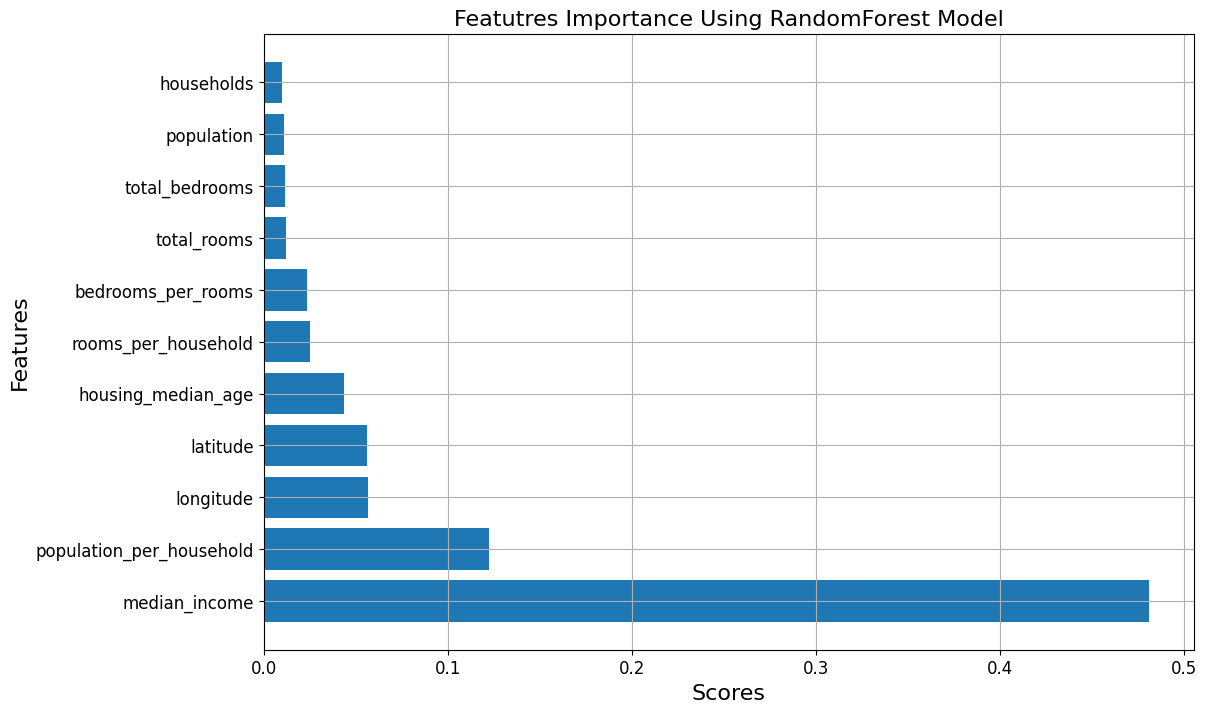

In [90]:
## to DF and then plotting
df_feat_import_forest = pd.DataFrame({'Features': keys_forest, 'Scores': values_forest})
df_feat_import_forest = df_feat_import_forest.sort_values(by='Scores', ascending=False)

## plotting
plt.figure(figsize=(12, 8))
plt.barh(y=df_feat_import_forest['Features'], width=df_feat_import_forest['Scores'])
plt.title('Featutres Importance Using RandomForest Model', fontsize=16, c='k')
plt.xlabel('Scores', fontsize=16, c='k')
plt.ylabel('Features', fontsize=16, c='k')
plt.xticks(c='k', fontsize=12)
plt.yticks(c='k', fontsize=12)
plt.grid('on')
plt.show()

### `8. XGboost`

In [92]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8)
xgb_reg.fit(X_train_final, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [93]:
rmse_scores_xgb = cross_val_score(estimator=xgb_reg, X=X_train_final, y=y_train, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  

rmse_scores_xgb = -1 * rmse_scores_xgb   ## we want it positive
rmse_scores_xgb = np.sqrt(rmse_scores_xgb)

print(f'RMSE Scores Using Tuned XGBoost --- {np.round(rmse_scores_xgb, 4)}')
print(f'Mean of RMSE Scores Using XGBoost --- {rmse_scores_xgb.mean():.4f}')

RMSE Scores Using Tuned XGBoost --- [46370.7538 48182.131  48115.3436 46180.4831 48203.4455]
Mean of RMSE Scores Using XGBoost --- 47410.4314


In [94]:
y_pred_xgb = cross_val_predict(estimator=xgb_reg, X=X_train_final, y=y_train, cv=5, 
                                        method='predict', n_jobs=-1)

rmse_pred_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
print(f'RMSE after prediction Using XGBoost --- {rmse_pred_xgb:.4f}') 

RMSE after prediction Using XGBoost --- 47419.4868


## Evaluating XGBoost Regressor with Cross-Validation

We evaluate the **XGBoost Regressor** model using **cross-validation** to get a reliable measure of performance.

---

### **1️ RMSE Scores using Cross-Validation**
- The training data is divided into multiple folds (e.g., 5 folds).  
- The model is trained on some folds and tested on the remaining fold in each iteration.  
- RMSE (Root Mean Squared Error) is calculated for each fold to measure performance.  
- scikit-learn returns negative MSE in `cross_val_score`; we convert it to positive and take the square root to obtain RMSE.  
- The mean RMSE across all folds provides an overall performance estimate for the XGBoost model.

---

### **2️ Predictions using Cross-Validation**
- `cross_val_predict` generates predictions for each training sample **as if it were part of a test fold**.  
- RMSE computed from these predictions should closely match the mean RMSE from cross-validation scores.  
- Important: **Do not use `.predict()` directly on training data** when performing cross-validation to avoid biased results.

---

###  **Key Takeaways**
- Cross-validation ensures **reliable and unbiased evaluation** of the XGBoost Regressor.  
- RMSE is used as a standard metric to measure regression performance.  
- Comparing cross-validation scores and predictions confirms model consistency and generalization.


### `Tuning XGBoost`

In [95]:
params_best_xgb = {'n_estimators': np.arange(100, 200, 50), 'max_depth': np.arange(4, 15, 2), 
                   'learning_rate': [0.1, 0.2], 'subsample': [0.8, 0.9]}


## Intitalize the GridSearchCV and Fit ti Data
grid_xgb = GridSearchCV(estimator=xgb_reg, param_grid=params_best_xgb, cv=5, 
                        scoring='neg_mean_squared_error', n_jobs=-1, verbose=6)
grid_xgb.fit(X_train_final, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'learning_rate': [0.1, 0.2], 'max_depth': array([ 4, 6..., 10, 12, 14]), 'n_estimators': array([100, 150]), 'subsample': [0.8, 0.9]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,6
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [96]:
## Get the best Params
best_xgb_params = grid_xgb.best_params_
print('best_xgb_params -- ', best_xgb_params)

## Get the best estimator
best_xgb = grid_xgb.best_estimator_  ## predict using this Model
print('best_xgb -- ', best_xgb)

best_xgb_params --  {'learning_rate': 0.1, 'max_depth': np.int64(8), 'n_estimators': np.int64(150), 'subsample': 0.8}
best_xgb --  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=np.int64(8),
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None,
             n_estimators=np.int64(150), n_jobs=None, num_parallel_tree=None, ...)


##  Hyperparameter Tuning for XGBoost Regressor using GridSearchCV

To optimize the performance of the **XGBoost Regressor**, we use **GridSearchCV** to find the best combination of hyperparameters.

---

### **1️ Hyperparameters Considered**
- `n_estimators`: Number of boosting rounds (e.g., 100, 150).  
- `max_depth`: Maximum depth of a tree (e.g., 4, 6, 8, 10, 12, 14).  
- `learning_rate`: Step size shrinkage used in each boosting step (e.g., 0.1, 0.2).  
- `subsample`: Fraction of training samples used for fitting each tree (e.g., 0.8, 0.9).

---

### **2️ How GridSearchCV Works**
- Exhaustively searches through all hyperparameter combinations defined in the grid.  
- Uses cross-validation (`cv=5`) to evaluate the performance of each combination.  
- Scoring metric: negative mean squared error (`neg_mean_squared_error`).  
- Verbose output shows progress during the search.  

---

### **3️ Results**
- `best_params_` provides the **optimal hyperparameters** for XGBoost.  
- `best_estimator_` returns the **XGBoost model trained with these optimal parameters**, ready for predictions.  

---

###  **Key Takeaways**
- Grid search ensures we **systematically find the best hyperparameters** for the model.  
- Cross-validation inside the grid search guarantees **unbiased performance estimation**.  
- Using the tuned XGBoost model often **improves prediction accuracy** significantly.


In [97]:
rmse_scores_tuned_xgb = cross_val_score(estimator=best_xgb, X=X_train_final, y=y_train, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1) 

rmse_scores_tuned_xgb = -1 * rmse_scores_tuned_xgb   ## we want it positive
rmse_scores_tuned_xgb = np.sqrt(rmse_scores_tuned_xgb)

print(f'RMSE Scores Using Tuned Tuned XGBoost --- {np.round(rmse_scores_tuned_xgb, 4)}')
print(f'Mean of RMSE Scores Using Tuned XGBoost --- {rmse_scores_tuned_xgb.mean():.4f}')

RMSE Scores Using Tuned Tuned XGBoost --- [44680.1699 47264.2161 46644.0516 45461.5905 46527.3367]
Mean of RMSE Scores Using Tuned XGBoost --- 46115.4729


In [98]:
y_pred_tuned_xgb = cross_val_predict(estimator=best_xgb, X=X_train_final, y=y_train, cv=5, 
                                        method='predict', n_jobs=-1)

rmse_pred_tuned_xgb = np.sqrt(mean_squared_error(y_train, y_pred_tuned_xgb))
print(f'RMSE after prediction Using Tuned XGBoost --- {rmse_pred_tuned_xgb:.4f}')

RMSE after prediction Using Tuned XGBoost --- 46124.6786


##  Evaluating Tuned XGBoost Regressor with Cross-Validation

After performing hyperparameter tuning using **GridSearchCV**, we evaluate the **best XGBoost model** with cross-validation to measure its performance.

---

### **1️ RMSE Scores using Cross-Validation**
- The training data is split into multiple folds (e.g., 5 folds).  
- The **tuned XGBoost model** is trained on some folds and tested on the remaining fold in each iteration.  
- RMSE (Root Mean Squared Error) is computed for each fold to assess performance.  
- scikit-learn returns negative MSE by default; we convert it to positive and take the square root to obtain RMSE.  
- The mean RMSE across all folds provides an overall performance estimate for the tuned XGBoost model.

---

### **2️ Predictions using Cross-Validation**
- `cross_val_predict` generates predictions for each training sample **as if it were part of a test fold**.  
- RMSE computed from these predictions should closely match the mean RMSE from cross-validation scores.  
- Important: **Do not use `.predict()` directly on training data** when performing cross-validation to avoid biased results.

---

###  **Key Takeaways**
- Hyperparameter tuning improves the **XGBoost model's performance** significantly.  
- Cross-validation ensures **reliable and unbiased evaluation** of the tuned model.  
- Comparing cross-validation scores and predictions confirms **model consistency and generalization**.


> `Feature Importance for tuned model of xgboost`
* `Importance_types`
    * `‘weight’ - the number of times a feature is used to split the data across all trees. --> I used this Method`
    * `‘gain’ - the average gain across all splits the feature is used in.`
    * `‘cover’ - the average coverage across all splits the feature is used in.`
    * `‘total_gain’ - the total gain across all splits the feature is used in.`
    * `‘total_cover’ - the total coverage across all splits the feature is used in.`

In [99]:
feat_import_xgb = best_xgb.get_booster().get_score(importance_type='weight')  ## the same as RF, but RF normalize
df_feat_import_xgb = pd.DataFrame.from_dict(feat_import_xgb, orient='index')   ## to DF
df_feat_import_xgb = df_feat_import_xgb.reset_index()
df_feat_import_xgb = df_feat_import_xgb.rename(columns={'index': 'Features', 0:'f_scores'})  ## Some Modification

## Only taking the first 11 Numerical Cols 
df_feat_import_xgb = df_feat_import_xgb[:11]   ## take only the first 11 Numerical Cols

# ## Some Sort to plot
df_feat_import_xgb['Features'] = num_cols
df_feat_import_xgb = df_feat_import_xgb.sort_values(by='f_scores', ascending=False)

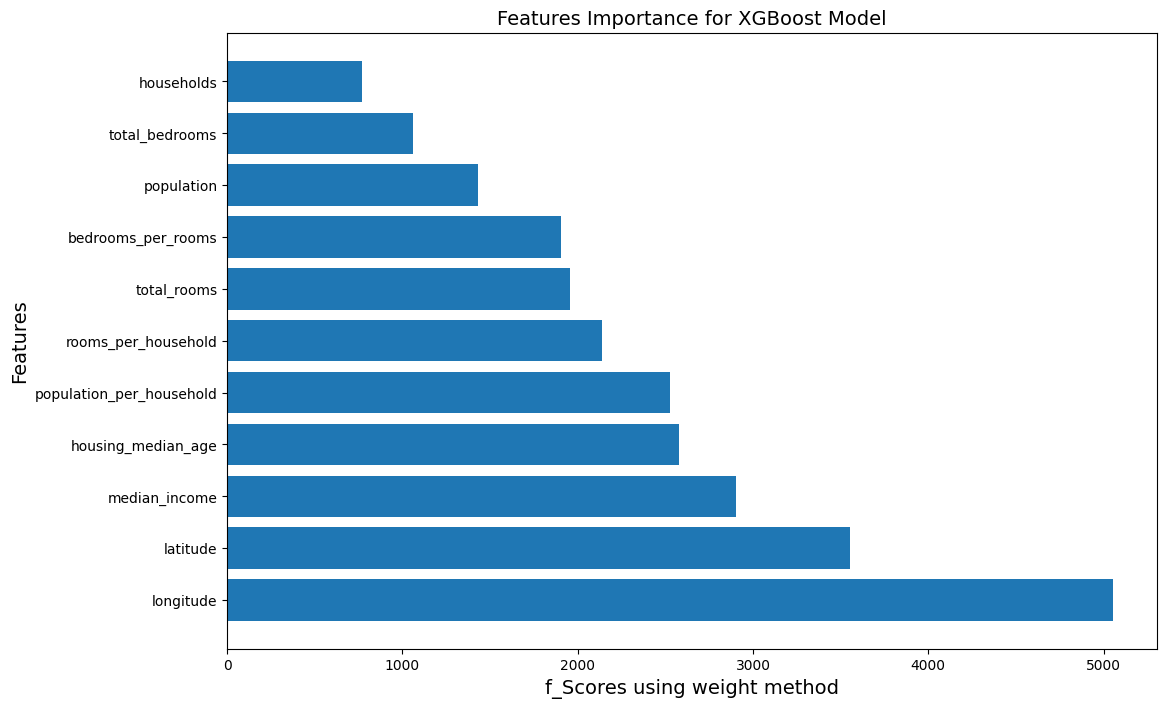

In [100]:
plt.figure(figsize=(12, 8))
plt.barh(y=df_feat_import_xgb['Features'], width=df_feat_import_xgb['f_scores'])
plt.title('Features Importance for XGBoost Model', fontsize=14, c='k')
plt.xlabel('f_Scores using weight method', fontsize=14, c='k')
plt.xticks(c='k')
plt.yticks(c='k')
plt.ylabel('Features', fontsize=14, c='k')
plt.show()

##  Feature Importance from Tuned XGBoost Regressor

After training the **best XGBoost model**, we can analyze which features are most influential for the predictions.

---

### **1️ How Feature Importance Works in XGBoost**
- XGBoost calculates feature importance based on **how often a feature is used to split the data** across all trees (weight method).  
- Features used more frequently in splitting nodes are considered **more important**.  
- Unlike Random Forest, XGBoost feature scores are **not normalized by default**.  

---

### **2️ Extracting Feature Importance**
- Feature importance values are stored in a dictionary (`feature_name → score`).  
- We can convert this dictionary to a DataFrame for easier handling and sorting.  
- Only the first 11 numerical features are typically considered for visualization to keep plots readable.  
- Sorting the features by their importance scores allows us to **identify the most influential variables**.

---

### **3️ Visualization**
- Horizontal bar plots are commonly used to visualize feature importance.  
- The y-axis lists features, while the x-axis shows their importance scores.  
- This visual summary helps **quickly identify key drivers** in the model's predictions.

---

###  **Key Takeaways**
- Feature importance provides insights into which variables **most strongly influence the target**.  
- This information can guide **feature selection, engineering, and interpretation** of model results.  
- Comparing feature importance across models (Random Forest vs XGBoost) can highlight **consistent influential features**.


### `VotingRegressor`

In [101]:
voting_reg = VotingRegressor(estimators=[
                                        ('tuned_forest', best_forest), 
                                        ('tuned_xgb', best_xgb)
                                        ]
                            )

voting_reg.fit(X_train_final, y_train)

,estimators,"[('tuned_forest', ...), ('tuned_xgb', ...)]"
,weights,None
,n_jobs,None
,verbose,False
,n_estimators,np.int64(400)
,criterion,'squared_error'
,max_depth,np.int64(18)
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0


## 🔹 Ensemble Learning: Voting Regressor

To further improve prediction performance, we can combine multiple models using **Voting Regressor**, an ensemble method.

---

### **1️ What is Voting Regressor**
- A **Voting Regressor** aggregates predictions from multiple base regressors and outputs the **average prediction**.  
- Ensemble learning often **reduces variance and improves generalization** compared to individual models.  
- Each base model contributes equally to the final prediction (unless weighted voting is used).  

---

### **2️ Base Models in this Project**
- **Tuned Random Forest Regressor**: captures non-linear relationships and feature interactions.  
- **Tuned XGBoost Regressor**: gradient boosting model optimized for prediction accuracy.  
- Combining both models leverages their **complementary strengths**.  

---

### **3️ Training the Ensemble**
- The Voting Regressor is **fit on the training data** just like any other model.  
- During prediction, it calculates the **average prediction** from each base model.  

---

###  **Key Takeaways**
- Ensemble methods like Voting Regressor can **improve robustness** and **accuracy**.  
- Combining tuned models is especially effective when base models have **different strengths**.  
- This approach is often used in **Kaggle competitions and real-world regression tasks**.


In [102]:
rmse_scores_voting = cross_val_score(estimator=voting_reg, X=X_train_final, y=y_train, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  

rmse_scores_voting = -1 * rmse_scores_voting   ## we want it positive
rmse_scores_voting = np.sqrt(rmse_scores_voting)

print(f'RMSE Scores Using VotingRegressor --- {np.round(rmse_scores_voting, 4)}')
print(f'Mean of RMSE Scores Using VotingRegressor --- {rmse_scores_voting.mean():.4f}')

RMSE Scores Using VotingRegressor --- [45642.4804 48847.4894 48009.7809 46153.3943 47411.749 ]
Mean of RMSE Scores Using VotingRegressor --- 47212.9788


In [103]:
y_pred_voting = cross_val_predict(estimator=voting_reg, X=X_train_final, y=y_train, cv=5, 
                                        method='predict', n_jobs=-1)

rmse_pred_voting = np.sqrt(mean_squared_error(y_train, y_pred_voting))
print(f'RMSE after prediction Using VotingRegressor --- {rmse_pred_voting:.4f}') 

RMSE after prediction Using VotingRegressor --- 47227.6552


##  Evaluating Voting Regressor with Cross-Validation

After combining the **Tuned Random Forest** and **Tuned XGBoost** models into a **Voting Regressor**, we evaluate its performance using cross-validation.

---

### **1️ RMSE Scores with Cross-Validation**
- The training dataset is split into multiple folds (e.g., 5 folds).  
- The Voting Regressor is trained on all folds except one, which is used for validation in each iteration.  
- RMSE (Root Mean Squared Error) is calculated for each fold.  
- Negative mean squared error returned by scikit-learn is converted to positive RMSE.  
- The mean RMSE provides an overall estimate of the ensemble model's performance.

---

### **2️ Predictions using Cross-Validation**
- `cross_val_predict` generates **predictions for each sample** as if it were in a test fold.  
- RMSE from these predictions should closely match the mean RMSE from cross-validation scores.  
- Important: **Do not use `.predict()` directly on training data** when performing cross-validation to avoid biased results.

---

###  **Key Takeaways**
- Voting Regressor often improves performance by **combining the strengths of different models**.  
- Cross-validation ensures the evaluation is **reliable and unbiased**.  
- Comparing predictions and cross-validation scores confirms **model consistency and robustness**.


### `Models Comparison`

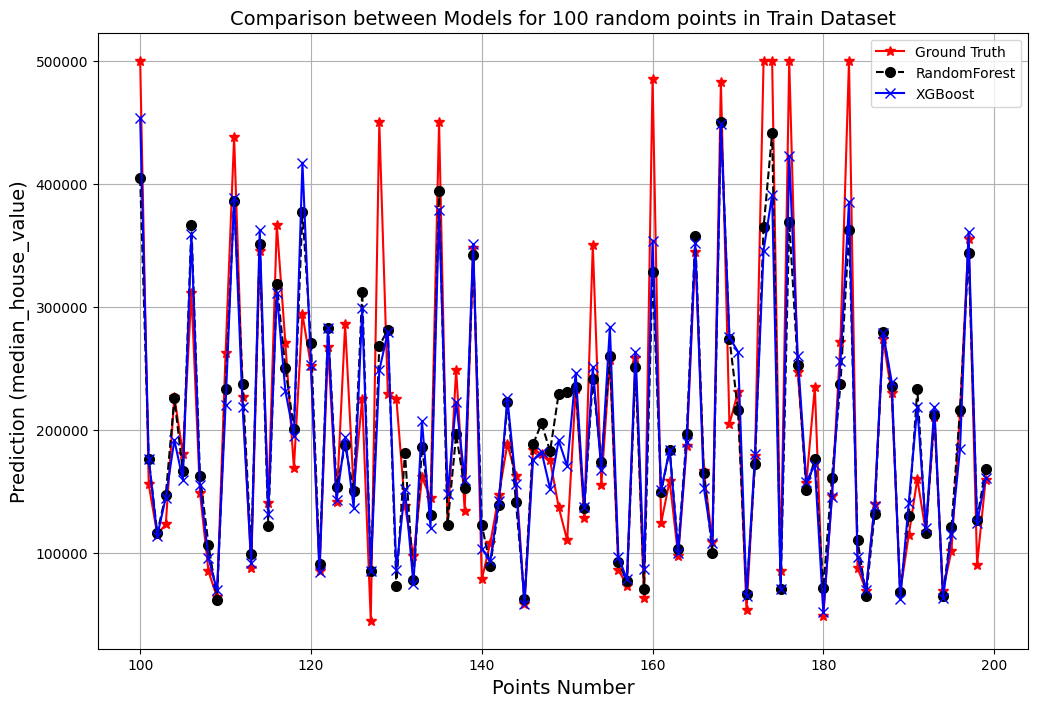

In [ ]:
## Plotting
x_x = np.arange(100, 200)  ## random selected points
## Plotting
plt.figure(figsize=(12, 8))
plt.plot(x_x, y_train.values[100:200], 'r*-',  markersize=7, label='Ground Truth')  ## for train
plt.plot(x_x, y_pred_tuned_forest[100:200], 'ko--', markersize=7, label='RandomForest')
plt.plot(x_x, y_pred_tuned_xgb[100:200], 'bx-', markersize=7, label='XGBoost')
plt.title('Comparison between Models for 100 random points in Train Dataset', fontsize=14, color='k')
plt.xlabel('Points Number', fontsize=14, color='k')
plt.ylabel('Prediction (median_house_value)', fontsize=14, color='k')
plt.legend()
plt.grid('on') 
plt.show()

##  Comparing Model Predictions on Sample Training Data

To visually compare the performance of different models, we plot predictions against the ground truth values for a subset of the training dataset.

---

### **1️ Purpose of the Plot**
- Select a random subset of data points from the training set.  
- Compare **ground truth values** with predictions from different models:  
  - Tuned Random Forest  
  - Tuned XGBoost  
- Helps to **visually assess how well each model fits the data** and identifies patterns or deviations.

---

### **2️ Interpretation**
- Each model's predictions are plotted with a distinct style and color for clarity.  
- Ideally, predicted values should closely follow the **ground truth trend**.  
- Deviations or gaps indicate areas where the model **underfits or overfits**.  
- Visual comparison complements RMSE scores, providing **intuitive understanding** of model performance.

---

###  **Key Takeaways**
- Visual inspection is useful to detect **prediction errors for specific samples**.  
- Helps in understanding **model behavior** beyond numeric metrics.  
- Can guide further **hyperparameter tuning** or feature engineering.


### `Download the best Model --- best_xgb`

In [106]:
joblib.dump(best_xgb, 'model_XGBoost.pkl')

['model_XGBoost.pkl']

In [107]:
loaded_model = joblib.load('model_XGBoost.pkl')
loaded_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [108]:
y_pred_test = loaded_model.predict(X_test_final) 

In [109]:
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'RMSE on test Dataset using XGBoost -- {rmse_test:.3f}')

RMSE on test Dataset using XGBoost -- 45397.872


### `Done by Eng / Mohamed Zahran`
`@22/11/2025`